<a href="https://colab.research.google.com/github/LLerzy/Estimation-Parameter-Beta/blob/Comparison/Metropolis_Hasting(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Packages

In [1]:
# Numerical Computation and Special Functions
import numpy as np
import math
import scipy.special as sp
from scipy.special import polygamma, gammaln

# Optimization and Root Finding
from scipy.optimize import newton, brentq, bisect, minimize

# Statistical Distributions and Bootstrapping
from scipy.stats import multivariate_normal, lognorm, bootstrap

# Integration
import scipy.integrate as spi

# Data Manipulation and Parallel Processing
import pandas as pd
from joblib import Parallel, delayed

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Models
import statsmodels.api as sm

# **Metropolis - Hasting**

In [ ]:
def metropolis_hastings(target_pdf, proposal_sampler, proposal_pdf, x0, n_samples, burn_in=1000, thinning=1):
    """
    Parameters:
    -----------
    target_pdf : function
        Bivariate target probability density function.
    proposal_sampler : function
        Function that generates a proposal from the proposal distribution.
    proposal_pdf : function
        Probability density function of the proposal distribution evaluated at a given point.
    x0 : tuple
        Initial value of the Markov chain (x1_0, x2_0).
    n_samples : int
        Total number of samples to store after the burn-in period.
    burn_in : int
        Number of initial samples to discard to remove dependency on the starting value.
    thinning : int
        Subsampling interval; only stores every 'thinning' iterations.

    Returns:
    --------
    samples : np.array
        Samples generated after the burn-in period and with thinning applied.
    acceptance_rate : float
        Acceptance rate of the algorithm.
    """

    samples = []
    x_current = np.array(x0)  # Initial state
    total_iterations = burn_in + n_samples * thinning  # Total number of iterations
    accepted_samples = 0  # Counter for accepted proposals
    i = 0  # Iteration counter

    while i < total_iterations:
        x_proposed = proposal_sampler(x_current)  # Generate proposal

        # Compute denominator of the acceptance ratio
        denominator = target_pdf(x_current) * proposal_pdf(x_proposed, x_current)

        # Check if the denominator is nonzero
        if denominator > 0:
            acceptance_ratio = (target_pdf(x_proposed) * proposal_pdf(x_current, x_proposed)) / denominator
            acceptance_ratio = min(1, acceptance_ratio)

            # Accept or reject the proposal
            if np.random.uniform(0, 1) < acceptance_ratio:
                x_current = x_proposed  # Accept proposal
                accepted_samples += 1  # Increment acceptance counter

        # Store sample only after the burn-in period and at every 'thinning' interval
        if i >= burn_in and (i - burn_in) % thinning == 0:
            samples.append(x_current)

        # Only increment i if the calculation was valid
        i += 1  # Advance iteration

    # Compute acceptance rate
    acceptance_rate = accepted_samples / total_iterations

    return np.array(samples), acceptance_rate

# Instrumental Distribution

In [ ]:
# Proposal: Product of two Log-Normal distributions
def proposal_sampler(y):
    mu1, sigma1 = np.log(y[0]), 0.1  # Parameters of the Log-Normal for Alpha
    mu2, sigma2 = np.log(y[1]), 0.1  # Parameters of the Log-Normal for Beta
    alpha_proposed = np.random.lognormal(mean=mu1, sigma=sigma1)
    beta_proposed = np.random.lognormal(mean=mu2, sigma=sigma2)
    return np.array([alpha_proposed, beta_proposed])

# Probability density function of the proposal distribution (Product of Log-Normal distributions)
# Given vector y, conditioned on vector z.
def proposal_pdf(y, z):
    mu1, sigma1 = np.log(z[0]), 0.1  # Parameters for Alpha
    mu2, sigma2 = np.log(z[1]), 0.1  # Parameters for Beta
    return lognorm.pdf(y[0], s=sigma1, scale=np.exp(mu1)) * lognorm.pdf(y[1], s=sigma2, scale=np.exp(mu2))

# Generation of Beta Samples

In [ ]:
def generate_beta_samples(a, b, size):
    np.random.seed(42)
    xn=np.random.beta(a, b, size=size)
    alpha0=np.mean(xn)*(np.mean(xn)*(1-np.mean(xn))/np.var(xn)-1)
    beta0=(1-np.mean(xn))*(np.mean(xn)*(1-np.mean(xn))/np.var(xn)-1)
    return xn, (alpha0,beta0)

xn, (alpha0,beta0) = generate_beta_samples(16, 4, 10)
print(alpha0,beta0)

31.97706646227431 6.858564710728487


# Function for Monitoring MCMC Convergence

In [ ]:
def monitor_convergence(x, y):
    # Plot the trace of the samples
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    axs[0].plot(x, color='blue', alpha=0.7)
    axs[0].set_title("Trace plot of the chain for $Alpha$")
    axs[1].plot(y, color='red', alpha=0.7)
    axs[1].set_title("Trace plot of the chain for $Beta$")
    plt.xlabel("Iterations")
    plt.show()

    # Histograms of the marginal distributions
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(x, bins=50, kde=True, color='blue', ax=axs[0])
    axs[0].set_title("Histogram of $Alpha$")
    sns.histplot(y, bins=50, kde=True, color='red', ax=axs[1])
    axs[1].set_title("Histogram of $Beta$")
    plt.show()

    # Scatter plot of the samples $(Alpha, Beta)$
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x, y=y, alpha=0.3)
    plt.xlabel("$Alpha$")
    plt.ylabel("$Beta$")
    plt.title("Scatter plot of the samples $(Alpha, Beta)$")
    plt.show()

    # Autocorrelation plots of the chains
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sm.graphics.tsa.plot_acf(x, lags=50, ax=axs[0], title="Autocorrelation of $Alpha$")
    sm.graphics.tsa.plot_acf(y, lags=50, ax=axs[1], title="Autocorrelation of $Beta$")
    plt.show()

# Posterior Distribution Using Gammas Prior Product

In [ ]:
def post_prior_gammas(x, alpha, beta, a, b, c, d):
    """
    Parameters:
    -----------
    x     : array-like -> Observed data (sample from a Beta distribution)
    alpha : float      -> Alpha parameter of the Beta distribution
    beta  : float      -> Beta parameter of the Beta distribution
    a     : float      -> Hyperparameter a0 (shape of the Gamma distribution)
    b     : float      -> Hyperparameter b0 (scale of the Gamma distribution)
    c     : float      -> Hyperparameter c0 (shape of the Gamma distribution)
    d     : float      -> Hyperparameter d0 (scale of the Gamma distribution)

    Returns:
    --------
    float -> Value of the posterior density function
    """
    from scipy.special import gammaln

    # Validations to avoid log(0) errors
    if alpha <= 0 or beta <= 0:
        return 0.0  # Prevent invalid values

    n = len(x)  # Sample size

    # Logarithm of the Beta function ratio for numerical stability
    log_beta_ratio = n * (gammaln(alpha + beta) - gammaln(alpha) - gammaln(beta))

    # Log-likelihood function
    log_likelihood = (alpha - 1) * np.sum(np.log(x)) + (beta - 1) * np.sum(np.log(1 - x))

    # Logarithm of the Gamma prior
    log_prior = ((a - 1) * np.log(alpha) + (c - 1) * np.log(beta) - b * alpha - d * beta)

    # Posterior density evaluation (exponentiate at the end to prevent underflow)
    log_post = log_beta_ratio + log_likelihood + log_prior
    return np.exp(log_post)

## Simulation: Metropolis-Hasting with Normal Random Walk

In [ ]:
# Hyperparameter values of the prior distribution
a0, b0, c0, d0 = 0.1, 0.1, 0.1, 0.1  # Initialization

# Define the bivariate target distribution (Posterior Beta - Prior Product of Gammas)
# The hyperparameter values a0, b0, c0, and d0 must be set.
# The variable xn represents the sample.
def target_pdf(y):
    return post_prior_gammas(xn, y[0], y[1], a0, b0, c0, d0)

# Simulation settings
n_samples = 15000
x0 = (alpha0, beta0)  # Initial point
burn_in = 5000

# Run Bivariate Metropolis-Hastings
samples, acceptance_rate = metropolis_hastings(target_pdf, proposal_sampler, proposal_pdf, x0, n_samples, burn_in, thinning=5)
print(f"Acceptance Rate: {acceptance_rate:.6f}")
print(f"Mean (alpha, beta): {np.mean(samples, axis=0)}")
print(f"Variance (alpha, beta): {np.var(samples, axis=0)}")

Acceptance Rate: 0.755325
Mean (alpha, beta): [15.21270031  3.39914624]
Variance (alpha, beta): [48.38956038  2.18383827]


### Resulting Chain

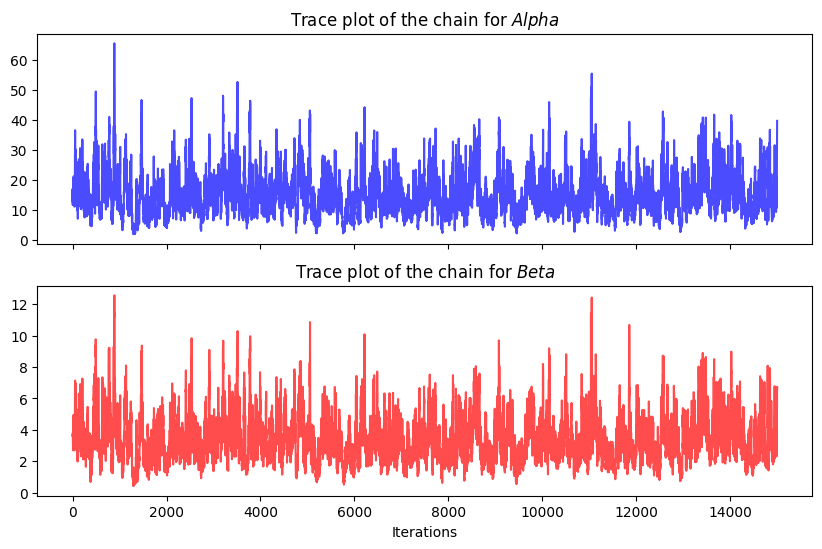

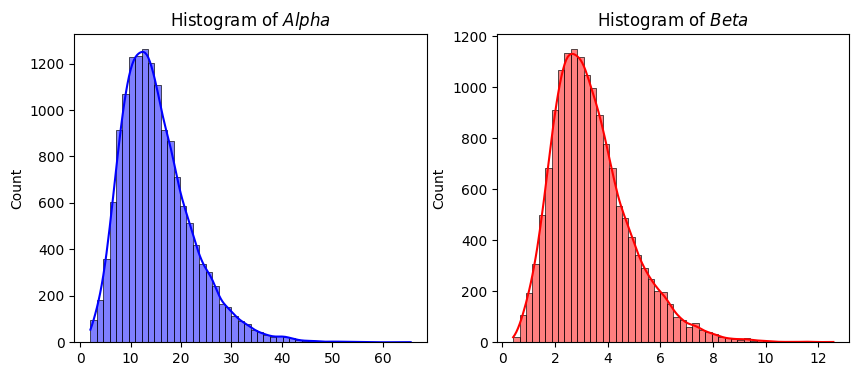

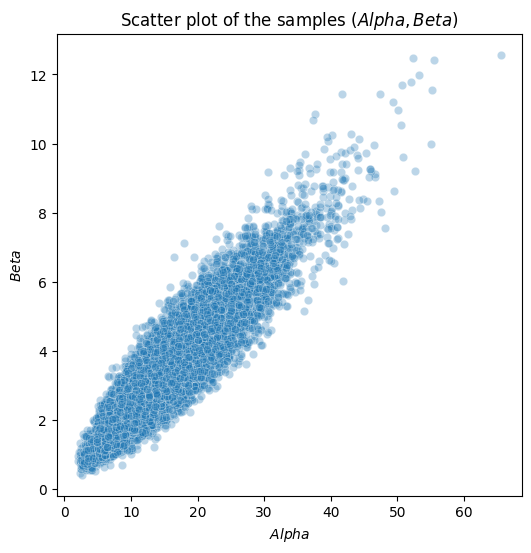

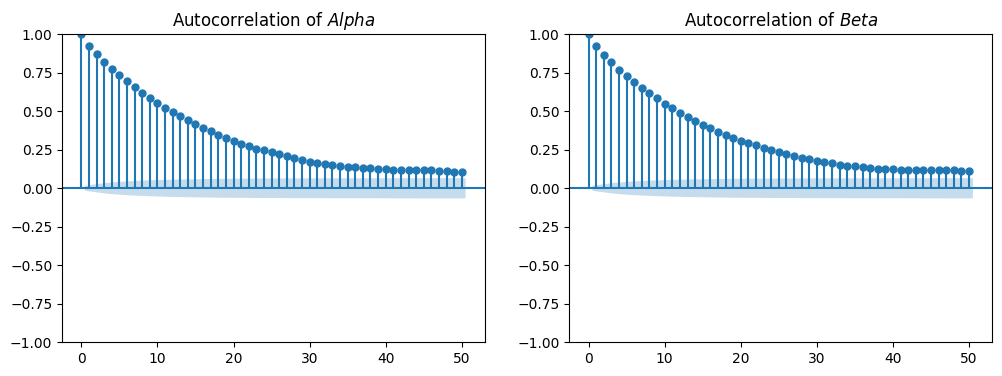

In [ ]:
# Separate samples denoted as (alpha_samples, beta_samples)
alpha_samples, beta_samples = samples[:, 0], samples[:, 1]

# Monitor the convergence of the chains
monitor_convergence(alpha_samples, beta_samples)

## Estimation-Maximization Method

In [ ]:
tol = 1e-6  # Convergence threshold

def target_pdf(y):
    return post_prior_gammas(xn, y[0], y[1], a0, b0, c0, d0)

def solve_with_fallback(func, dfunc, point0, tol=1e-6):
    """
    Attempts to solve a root-finding problem using Newton-Raphson.
    If Newton-Raphson fails, switches to Brent's method as a fallback.

    Parameters:
    -----------
    func : function
        Function for which the root is being found.
    dfunc : function
        Derivative of the function (needed for Newton-Raphson).
    point0 : float
        Initial guess for the root.
    tol : float, optional
        Tolerance level for convergence (default: 1e-6).

    Returns:
    --------
    float
        Estimated root of the function.
    """
    try:
        return newton(func, fprime=dfunc, x0=point0, tol=tol)
    except RuntimeError:
        print("Newton-Raphson did not converge, switching to Brent...")
        return brentq(func, 0.01, 500)  # Search for the root within a reasonable interval

def EM_Size():
    """
    Runs the EM algorithm for different sample sizes and scenarios,
    using Metropolis-Hastings.

    Returns:
    --------
    df_results : pd.DataFrame
        A DataFrame containing the final hyperparameter estimates
        and acceptance rates for each scenario and sample size.
    """

    sample_sizes = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200]
    scenarios = [(0.5, 0.5), (16, 4), (3, 12)]
    results = []

    for n in sample_sizes:
        for scenario in scenarios:
            a0, b0, c0, d0 = 0.01, 0.01, 0.01, 0.01  # Initial hyperparameters
            samplesabcd = []
            xn, estimpar = generate_beta_samples(scenario[0], scenario[1], n)

            for i in range(30):  # Maximum iterations for EM algorithm
                print(f"Iteration {i+1}: Running Metropolis-Hastings...")
                samples, acceptance_rate = metropolis_hastings(target_pdf, proposal_sampler, proposal_pdf, estimpar,
                                                               n_samples=5000, burn_in=1000, thinning=1)
                print(f"Acceptance Rate: {acceptance_rate:.4f}")

                # Extract (s, m) samples
                alpha_samples, beta_samples = samples[:, 0], samples[:, 1]
                post_alpha_t = np.mean(alpha_samples)
                post_log_alpha_t = np.mean(np.log(alpha_samples))
                post_beta_t = np.mean(beta_samples)
                post_log_beta_t = np.mean(np.log(beta_samples))

                def solve_a(a):
                    return np.log(a) - np.log(post_alpha_t) - polygamma(0, a) + post_log_alpha_t

                def solve_derivative_a(a):
                    return 1/a - polygamma(1, a)

                a_solution = solve_with_fallback(solve_a, solve_derivative_a, a0)
                b_solution = a_solution / post_alpha_t

                def solve_c(c):
                    return np.log(c) - np.log(post_beta_t) - polygamma(0, c) + post_log_beta_t

                def solve_c_derivative(c):
                    return 1/c - polygamma(1, c)

                c_solution = solve_with_fallback(solve_c, solve_c_derivative, c0)
                d_solution = c_solution / post_beta_t

                # Compute differences for convergence check
                diff_a = abs((a_solution - a0))
                diff_b = abs((b_solution - b0))
                diff_c = abs((c_solution - c0))
                diff_d = abs((d_solution - d0))

                print(f"Updated hyperparameters: a={a_solution:.6f}, b={b_solution:.6f}, c={c_solution:.6f}, d={d_solution:.6f}")
                print(f"Relative differences: Δa={diff_a:.6e}, Δb={diff_b:.6e}, Δc={diff_c:.6e}, Δd={diff_d:.6e}")

                # Check for convergence
                if max(diff_a, diff_b, diff_c, diff_d) < tol:
                    print("✅ Convergence reached. Stopping iterations.")
                    break

                # Update hyperparameters for next iteration
                a0, b0, c0, d0 = a_solution, b_solution, c_solution, d_solution
                samplesabcd.append([a0, b0, c0, d0])
                print("Final hyperparameters:", samplesabcd[-1])

            # Store results in DataFrame
            row = {
                'n': n, 'alpha_true': scenario[0], 'beta_true': scenario[1],
                'a': a0, 'b': b0, 'c': c0, 'd': d0,
                'acceptance_rate': acceptance_rate
            }
            results.append(row)

    df_results = pd.DataFrame(results)
    return df_results

In [ ]:
EM_results=EM_Size()

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Diferencias relativas: Δa=5.424779e-01, Δb=8.009556e-02, Δc=3.919867e-01, Δd=3.145761e-01
Hiperparámetros finales: [5.27010949493918, 0.3144962814656346, 6.181534301959021, 1.6706663251628178]
Iteración 27: Ejecutando Metropolis-Hastings...
Tasa de aceptación: 0.7523
Nuevos valores de hiperparámetros: a=4.363327, b=0.266523, c=4.677107, d=1.300577
Diferencias relativas: Δa=9.067829e-01, Δb=4.797299e-02, Δc=1.504427e+00, Δd=3.700894e-01
Hiperparámetros finales: [4.363326565079772, 0.2665232895487673, 4.677107198656287, 1.300576888212884]
Iteración 28: Ejecutando Metropolis-Hastings...
Tasa de aceptación: 0.7728
Nuevos valores de hiperparámetros: a=4.078800, b=0.301044, c=4.600273, d=1.492746
Diferencias relativas: Δa=2.845262e-01, Δb=3.452023e-02, Δc=7.683392e-02, Δd=1.921689e-01
Hiperparámetros finales: [4.078800357644048, 0.30104351621972797, 4.60027328246384, 1.4927457503301742]
Iteración 29: Ejecutando Metropolis-Has

## Load Hyperparameter values obtained by the EM method for the Gamma Distributions product

In [2]:
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe

# Authenticate with Google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet_name = "Results_of_simulations_executed"
worksheet_name = "EM"

# Open the Google Sheet and retrieve data as a DataFrame
sh = gc.open(spreadsheet_name)
worksheet = sh.worksheet(worksheet_name)
EM_results = get_as_dataframe(worksheet, evaluate_formulas=True)

# Convert columns to appropriate data types
EM_results = EM_results.dropna().astype({
    'n': int,
    'alpha_true': float,
    'beta_true': float,
    'a': float,
    'b': float,
    'c': float,
    'd': float,
    'acceptance_rate': float
})

In [3]:
EM_results

,n,alpha_true,beta_true,a,b,c,d,acceptance_rate
0,10,0.5,0.5,4.858744,0.314189,5.500665,1.583593,0.764667
1,15,0.5,0.5,4.587011,0.301387,5.281744,1.541488,0.771333
2,20,0.5,0.5,4.910465,0.327411,5.475223,1.616833,0.767500
3,25,0.5,0.5,4.358449,0.290818,4.964454,1.466795,0.768167
4,30,0.5,0.5,4.734141,0.310459,5.262288,1.532952,0.766833
5,35,0.5,0.5,4.888193,0.314498,5.622336,1.609425,0.765667
6,40,0.5,0.5,4.992314,0.319166,5.637642,1.601882,0.765000
7,45,0.5,0.5,4.900598,0.321139,5.573919,1.622384,0.766333
8,50,0.5,0.5,4.599961,0.305620,5.232146,1.541631,0.772667
9,100,0.5,0.5,5.019141,0.311476,5.677453,1.577687,0.765000


# Posterior Distribution Using Jeffreys Prior

In [ ]:
def post_prior_Jeffrey(x, alpha, beta):
    """
    Computes the posterior density function under Jeffreys prior.

    Parameters:
    -----------
    alpha : float -> Alpha parameter of the Beta distribution
    beta  : float -> Beta parameter of the Beta distribution

    Returns:
    --------
    float -> Value of the posterior density function
    """
    from scipy.special import gammaln

    # Jeffrey's prior computation
    psi_alpha = polygamma(1, alpha)  # ψ^(1)(α)
    psi_beta = polygamma(1, beta)    # ψ^(1)(β)
    psi_alpha_beta = polygamma(1, alpha + beta)  # ψ^(1)(α + β)
    prior_jeffrey = np.sqrt(psi_alpha * psi_beta - (psi_alpha + psi_beta) * psi_alpha_beta)

    n = len(x)  # Sample size

    # Logarithm of the Beta function ratio for numerical stability
    log_beta_ratio = n * (gammaln(alpha + beta) - gammaln(alpha) - gammaln(beta))

    # Exponential term in the posterior density
    log_exp_term = (alpha - 1) * np.sum(np.log(x)) + (beta - 1) * np.sum(np.log(1 - x))

    # Posterior density evaluation (exponentiating at the end to prevent underflow)
    log_post = log_beta_ratio + log_exp_term + np.log(prior_jeffrey)
    return np.exp(log_post)

## Simulation: Metropolis-Hasting with Normal Random Walk

In [ ]:
# Define the bivariate target distribution (Posterior Beta - Jeffreys' Prior)
# The variable xn represents the sample.
def target_pdf(y):
    return post_prior_Jeffrey(xn, y[0], y[1])

# Simulation settings
n_samples = 10000
x0 = (alpha0, beta0)  # Punto inicial
burn_in = 5000

# Run Bivariate Metropolis-Hastings
samples, acceptance_rate = metropolis_hastings(target_pdf, proposal_sampler, proposal_pdf, x0, n_samples, burn_in, thinning=5)
print(f"Acceptance Rate: {acceptance_rate:.6f}")
print(f"Mean (alpha, beta): {np.mean(samples, axis=0)}")
print(f"Variance (alpha, beta): {np.var(samples, axis=0)}")

Acceptance Rate: 0.694036
Mean (alpha, beta): [28.07486253  5.9935231 ]
Variance (alpha, beta): [156.98532089   6.74439104]


### Resulting Chain

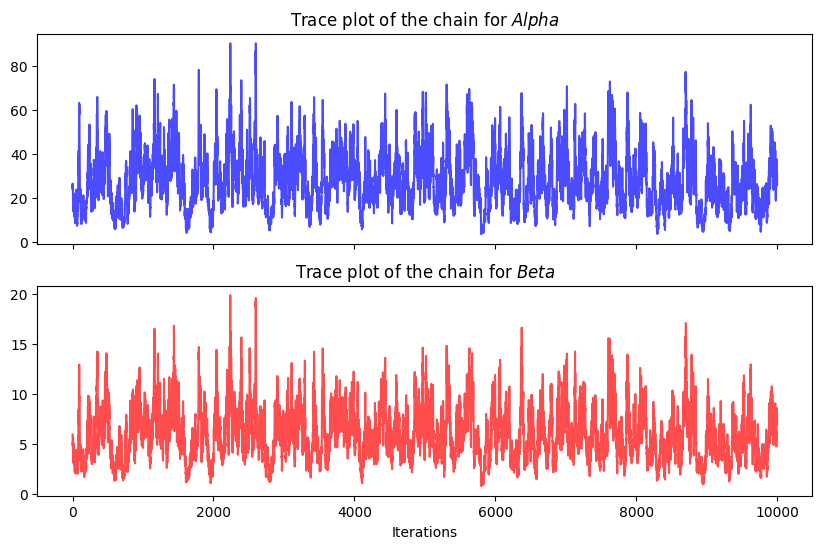

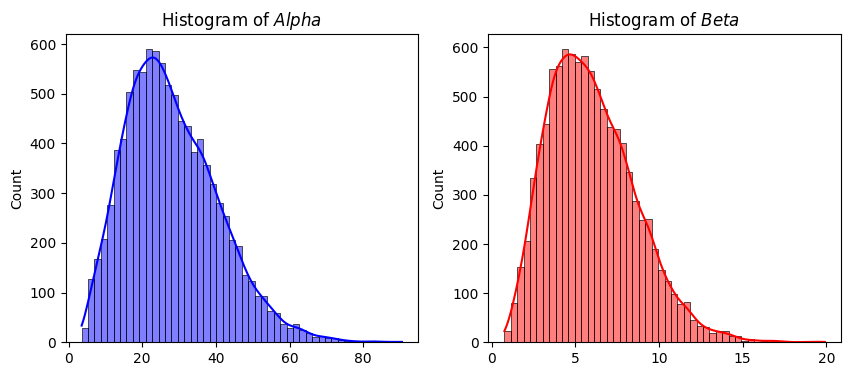

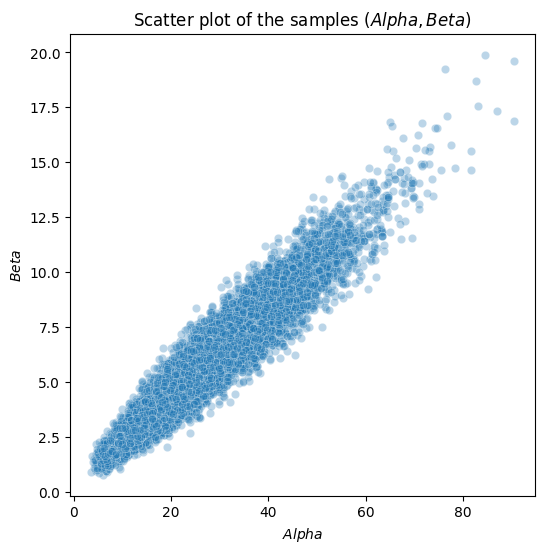

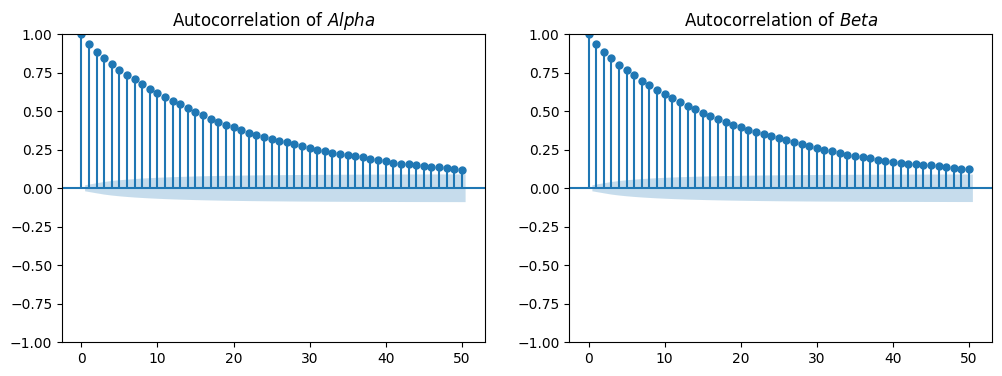

In [ ]:
# Separate samples denoted as (alpha_samples, beta_samples)
alpha_samples, beta_samples = samples[:, 0], samples[:, 1]

# Monitor the convergence of the chains
monitor_convergence(alpha_samples, beta_samples)

# Posterior Distribution Using the New Bivariate Prior Distribution

In [ ]:
def post_new_prior(x, alpha, beta, a, b, c, d):
    """
    Parameters:
    -----------
    alpha : float -> Alpha parameter of the Beta distribution
    beta  : float -> Beta parameter of the Beta distribution

    Returns:
    --------
    float -> Value of the posterior density function
    """
    from scipy.special import gammaln

    # New Bivariate Prior
    log_prior = (a - 1) * np.log(alpha) + (b - 1) * np.log(beta) + (d - (a + b)) * np.log(alpha + beta) - (c + d) * np.log(alpha + beta + 1)

    n = len(x)  # Sample size

    # Logarithm of the Beta function ratio for numerical stability
    log_beta_ratio = n * (gammaln(alpha + beta) - gammaln(alpha) - gammaln(beta))

    # Exponential term in the posterior density
    log_exp_term = (alpha - 1) * np.sum(np.log(x)) + (beta - 1) * np.sum(np.log(1 - x))

    # Posterior density evaluation (exponentiating at the end to prevent underflow)
    log_post = log_beta_ratio + log_exp_term + log_prior
    return np.exp(log_post)

## Simulation: Metropolis-Hasting with Normal Random Walk

In [ ]:
# Hyperparameter values ​​obtained from the first simulation study performed.
a0, b0, c0, d0 =  100.952, 23.680, 10.311, 111.771


# Define the bivariate target distribution (Posterior Beta - new bivariate prior distribution)
# The hyperparameter values a0, b0, c0, and d0 must be set.
# The variable xn represents the sample.
def target_pdf(y):
    return post_new_prior(xn, y[0], y[1], a0, b0, c0, d0)

# Simulation settings
n_samples = 10000
x0 = (alpha0, beta0)  # Punto inicial
burn_in = 5000

# Run Bivariate Metropolis-Hastings
samples, acceptance_rate = metropolis_hastings(target_pdf, proposal_sampler, proposal_pdf, x0, n_samples, burn_in, thinning=5)
print(f"Acceptance Rate: {acceptance_rate:.6f}")
print(f"Mean (alpha, beta): {np.mean(samples, axis=0)}")
print(f"Variance (alpha, beta): {np.var(samples, axis=0)}")

Acceptance Rate: 0.700636
Mean (alpha, beta): [12.94315352  2.978794  ]
Variance (alpha, beta): [19.42244114  0.99887195]


### Resulting Chain

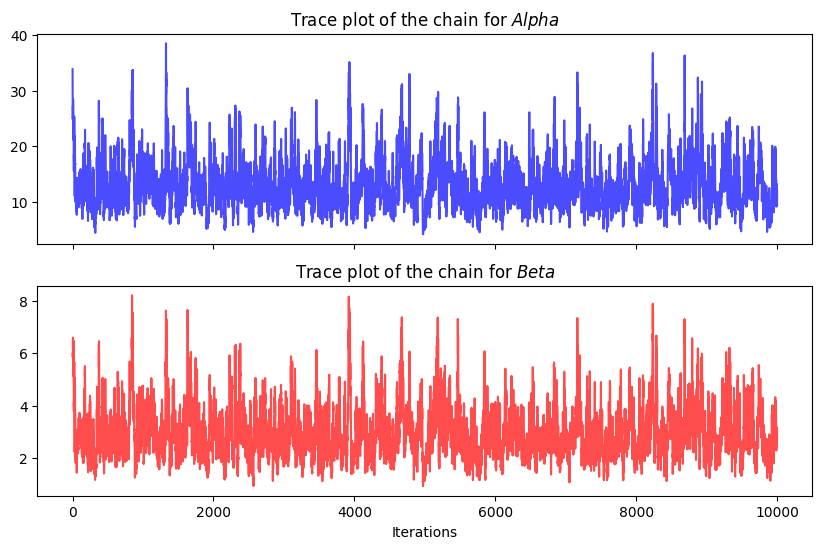

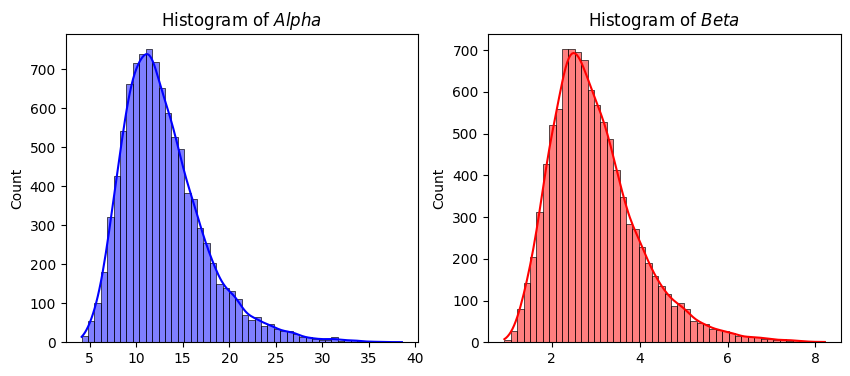

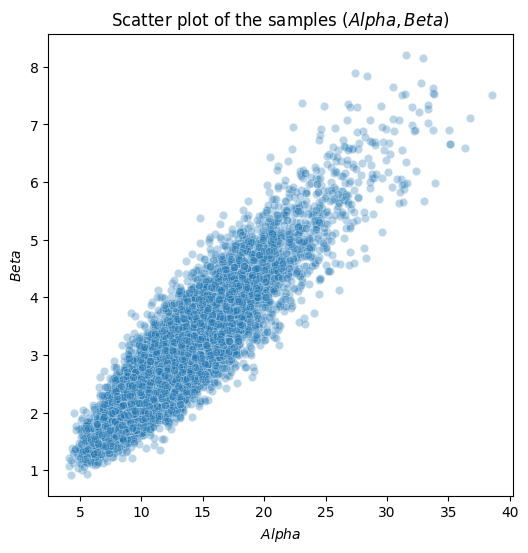

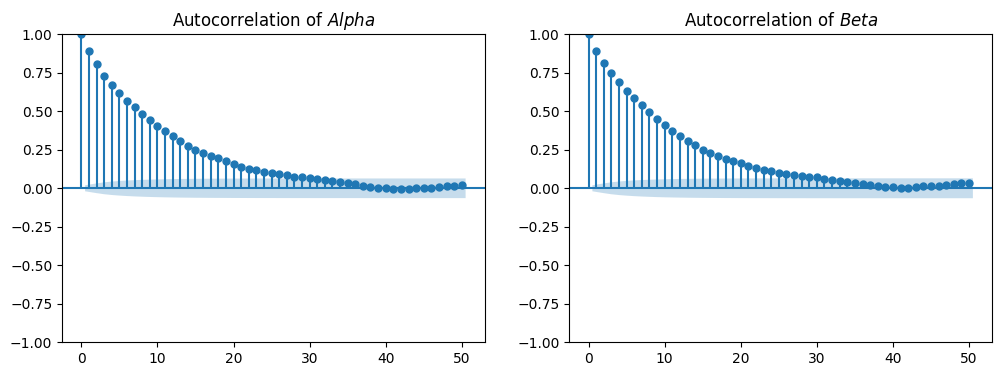

In [ ]:
# Separate samples denoted as (alpha_samples, beta_samples)
alpha_samples, beta_samples = samples[:, 0], samples[:, 1]

# Monitor the convergence of the chains
monitor_convergence(alpha_samples, beta_samples)

# Comparative (Parallelized Code)

In [ ]:
def generate_beta_samples(a, b, size):
    np.random.seed(42)
    xn=np.random.beta(a, b, size=size)
    alpha0=np.mean(xn)*(np.mean(xn)*(1-np.mean(xn))/np.var(xn)-1)
    beta0=(1-np.mean(xn))*(np.mean(xn)*(1-np.mean(xn))/np.var(xn)-1)
    return xn, (alpha0,beta0)

def mle_estimation(xn,x0=[1,1]):
    def negative_log_likelihood(params):
        alpha, beta = params
        return -np.sum((alpha - 1) * np.log(xn) + (beta - 1) * np.log(1 - xn)) - len(xn) * (gammaln(alpha + beta) - gammaln(alpha) - gammaln(beta))
    result = minimize(negative_log_likelihood, x0, bounds=[(0.01, None), (0.01, None)])
    return result.x if result.success else (np.nan, np.nan)

def method_of_moments(xn):
    from scipy.special import gammaln
    mean_x = np.mean(xn)
    var_x = np.var(xn)
    alpha = mean_x * ((mean_x * (1 - mean_x) / var_x) - 1)
    beta = (1 - mean_x) * ((mean_x * (1 - mean_x) / var_x) - 1)
    return alpha, beta

def bootstrap_intervals(estimation_func, xn, num_samples=1000, ci=95):
    boot_samples = [estimation_func(np.random.choice(xn, size=len(xn), replace=True)) for _ in range(num_samples)]
    boot_samples = np.array(boot_samples)
    lower_alpha, upper_alpha = np.nanpercentile(boot_samples[:, 0], [(100 - ci) / 2, 100 - (100 - ci) / 2],)
    lower_beta, upper_beta = np.nanpercentile(boot_samples[:, 1], [(100 - ci) / 2, 100 - (100 - ci) / 2])
    length_alpha = upper_alpha - lower_alpha
    length_beta = upper_beta - lower_beta
    mean_alpha, var_alpha = np.nanmean(boot_samples[:, 0]), np.nanvar(boot_samples[:, 0])
    mean_beta, var_beta = np.nanmean(boot_samples[:, 1]), np.nanvar(boot_samples[:, 1])
    return (mean_alpha, var_alpha, lower_alpha, upper_alpha, length_alpha, np.sum(np.isnan(boot_samples[:,0]))), (mean_beta, var_beta, lower_beta, upper_beta, length_beta, np.sum(np.isnan(boot_samples[:,1])))

def calculate_metrics(mh_samples, true_alpha, true_beta):
    mean_alpha = np.mean(mh_samples[:, 0])
    mean_beta = np.mean(mh_samples[:, 1])
    bias_alpha = mean_alpha - true_alpha
    bias_beta = mean_beta - true_beta
    mse_alpha = np.mean((mh_samples[:, 0] - true_alpha)**2)
    mse_beta = np.mean((mh_samples[:, 1] - true_beta)**2)
    ci_alpha = np.percentile(mh_samples[:, 0], [2.5, 97.5])
    ci_beta = np.percentile(mh_samples[:, 1], [2.5, 97.5])
    coverage_alpha = 1 if true_alpha >= ci_alpha[0] and true_alpha <= ci_alpha[1] else 0
    coverage_beta = 1 if true_beta >= ci_beta[0] and true_beta <= ci_beta[1] else 0
    length_alpha = ci_alpha[1] - ci_alpha[0]
    length_beta = ci_beta[1] - ci_beta[0]
    return mean_alpha, mean_beta, bias_alpha, bias_beta, mse_alpha, mse_beta, coverage_alpha, coverage_beta, length_alpha, length_beta

def process_scenario(n, scenario, prior, samples, estimpar):
    from scipy.special import gammaln
    new_prior_params = {
        (0.5,0.5): {'EM1': (103.530, 99.470, 73.651, 58.145), 'ET1': (259.590, 249.410, 66.904, 52.819), 'BM':(12.723, 19.188, 8.375, 8.225), 'BT':(35.052, 49.563, 5.663, 3.468)},
        (16,4): {'EM1': (100.952, 23.680, 10.311, 111.771), 'ET1': (253.596, 59.486, 9.366, 101.527), 'BM':(295.729, 55.660, 13.167, 477.498), 'BT':(776.586, 150.072, 15.106, 468.644)},
        (3,12): {'EM1': (28.230, 106.199, 84.448, 1299.674), 'ET1': (70.890, 266.681, 76.765, 1181.436), 'BM':(45.739, 137.916, 14.125, 164.970), 'BT':(112.941, 332.584, 15.884, 190.604)}
    }
    if prior in ['MLE', 'Method of Moments']:
        estimation_func = mle_estimation if prior == 'MLE' else method_of_moments
        about_alpha, about_beta = bootstrap_intervals(estimation_func, samples)
        est_alpha, est_beta = about_alpha[0], about_beta[0]
        bias_alpha, bias_beta = (est_alpha - scenario[0]), (est_beta - scenario[1])
        mse_alpha, mse_beta = (about_alpha[1] + bias_alpha**2), (about_beta[1] + bias_beta**2)
        coverage_alpha = 1 if about_alpha[2] <= scenario[0] <= about_alpha[3] else 0
        coverage_beta = 1 if about_beta[2] <= scenario[1] <= about_beta[3] else 0
        length_alpha, length_beta = about_alpha[4], about_beta[4]
        acceptance_rate = max(about_alpha[5],about_beta[5])
    else:
        if prior == 'Jeffrey':
            target_pdf = lambda y: post_prior_Jeffrey(samples, y[0], y[1])
        elif prior == 'Uninformative':
            target_pdf = lambda y: post_prior_gammas(samples, y[0], y[1], a=0.1, b=0.1, c=0.1, d=0.1)
        elif 'New Distribution' in prior:
            set_name = prior.split('(')[-1].strip(')')
            a, b, c, d = new_prior_params[scenario][set_name]
            target_pdf = lambda y: post_new_prior(samples, y[0], y[1], a, b, c, d)
        elif prior == 'EM-Based Gamma':
            em_row = EM_results[(EM_results['n'] == n) & (EM_results['alpha_true'] == scenario[0]) & (EM_results['beta_true'] == scenario[1])]
            if not em_row.empty:
               a, b, c, d = em_row.iloc[0][['a', 'b', 'c', 'd']]
               target_pdf = lambda y: post_prior_gammas(samples, y[0], y[1], a, b, c, d)
        mh_samples, acc_rate = metropolis_hastings(target_pdf, proposal_sampler, proposal_pdf, x0=(estimpar[0], estimpar[1]), n_samples=10000,burn_in=5000,thinning=3)
        metrics = calculate_metrics(mh_samples, scenario[0], scenario[1])
        est_alpha, est_beta = metrics[0], metrics[1]
        bias_alpha, bias_beta = metrics[2], metrics[3]
        mse_alpha, mse_beta = metrics[4], metrics[5]
        coverage_alpha, coverage_beta = metrics[6], metrics[7]
        length_alpha, length_beta = metrics[8], metrics[9]
        acceptance_rate = acc_rate
    return {'n': n, 'alpha_true': scenario[0], 'beta_true': scenario[1], 'prior': prior,
            'mean_alpha': est_alpha, 'mean_beta': est_beta,
            'bias_alpha': bias_alpha, 'bias_beta': bias_beta,
            'mse_alpha': mse_alpha, 'mse_beta': mse_beta,
            'coverage_alpha': coverage_alpha, 'coverage_beta': coverage_beta,
            'length_alpha': length_alpha, 'length_beta': length_beta,
            'acceptance_rate': acceptance_rate}

def comparative_study(EM_results):
    sample_sizes = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200]
    scenarios = [(0.5,0.5), (16,4), (3,12)]
    priors = ['Jeffrey', 'Uninformative', 'New Distribution (EM1)', 'New Distribution (ET1)', 'New Distribution (BM)', 'New Distribution (BT)', 'EM-Based Gamma', 'MLE', 'Method of Moments']
    results = Parallel(n_jobs=7, backend='multiprocessing')(delayed(process_scenario)(n, scenario, prior, *generate_beta_samples(scenario[0], scenario[1], n))
                                  for n in sample_sizes for scenario in scenarios for prior in priors)
    df_results = pd.DataFrame(results)
    return df_results

In [ ]:
results_3=comparative_study(EM_results)

## Load results obtained by the parallelized code

In [5]:
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe

# Authenticate with Google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet_name = "Results_of_simulations_executed"
worksheet_name = "PostEst"

# Open the Google Sheet and retrieve data as a DataFrame
sh = gc.open(spreadsheet_name)
worksheet = sh.worksheet(worksheet_name)
results_3 = get_as_dataframe(worksheet, evaluate_formulas=True)

# Convert columns to appropriate data types
results_3 = results_3.dropna().astype({
    'n': int,
    'alpha_true': float,
    'beta_true': float,
    'prior': str,
    'mean_alpha': float,
    'mean_beta': float,
    'bias_alpha': float,
    'bias_beta': float,
    'mse_alpha': float,
    'mse_beta': float,
    'coverage_alpha': float,
    'coverage_beta': float,
    'length_alpha': float,
    'length_beta': float,
    'acceptance_rate': float
})

In [6]:
results_3

,n,alpha_true,beta_true,prior,mean_alpha,mean_beta,bias_alpha,bias_beta,mse_alpha,mse_beta,coverage_alpha,coverage_beta,length_alpha,length_beta,acceptance_rate
0,10,16.0,4.0,EM-Based Gamma,17.862788,3.864401,1.862788,-0.135599,28.017822,1.028450,1.0,1.0,19.337382,3.883874,0.713400
1,10,3.0,12.0,EM-Based Gamma,2.509319,7.048169,-0.490681,-4.951831,0.726762,28.588453,1.0,0.0,2.708451,7.790544,0.758857
2,10,0.5,0.5,EM-Based Gamma,0.916355,1.284787,0.416355,0.784787,0.238472,0.757428,1.0,0.0,0.989837,1.439712,0.810657
3,10,16.0,4.0,Jeffrey,29.776706,6.359314,13.776706,2.359314,364.521700,13.096207,1.0,1.0,51.204473,10.608389,0.694057
4,10,3.0,12.0,Jeffrey,4.459933,16.447631,1.459933,4.447631,6.018459,76.913518,1.0,1.0,7.422220,28.549444,0.735771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,200,3.0,12.0,New Distribution (ET1),3.029891,12.060629,0.029891,0.060629,0.053586,0.871601,1.0,1.0,0.908927,3.706012,0.276571
320,200,0.5,0.5,New Distribution (ET1),0.440534,0.458965,-0.059466,-0.041035,0.004682,0.002995,1.0,1.0,0.130252,0.142633,0.376714
321,200,16.0,4.0,Uninformative,17.900738,4.543019,1.900738,0.543019,6.792535,0.485233,1.0,1.0,6.971369,1.722378,0.262143
322,200,3.0,12.0,Uninformative,2.958484,11.787222,-0.041516,-0.212778,0.086172,1.554843,1.0,1.0,1.150863,4.825555,0.307343


## Graphics of results

In [ ]:
def plot_results(data_results, char):
    """
    Parameters:
    -----------
    data_results : DataFrame
        Data containing sample size, estimation methods, and computed metrics.
    char : list
        List of column names corresponding to different metrics in the dataset.
    """

    # Set plot style
    sns.set(style="whitegrid")

    # Create subplots for different evaluation metrics
    fig, axes = plt.subplots(5, 1, figsize=(7, 12), sharex=True)

    # Plot 1: Estimated Alpha
    sns.lineplot(data=data_results, x="n", y=char[0], hue="prior", marker="o", ax=axes[0])
    axes[0].set_title(" ")
    axes[0].set_ylabel(char[5])
    axes[0].legend(title="Method")

    # Plot 2: Bias
    sns.lineplot(data=data_results, x="n", y=char[1], hue="prior", marker="o", ax=axes[1])
    axes[1].set_title(" ")
    axes[1].set_ylabel("Bias")
    axes[1].legend(title="Method")

    # Plot 3: Mean Squared Error (MSE)
    sns.lineplot(data=data_results, x="n", y=char[2], hue="prior", marker="o", ax=axes[2])
    #axes[2].set_ylim(0, 0.2)
    axes[2].set_title("")
    axes[2].set_ylabel("MSE")
    axes[2].legend(title="Method")

    # Plot 4: Coverage
    sns.lineplot(data=data_results, x="n", y=char[3], hue="prior", marker="o", ax=axes[3])
    axes[3].set_title("")
    axes[3].set_ylabel("Coverage")
    axes[3].legend(title="Method")

    # Plot 5: Interval Length
    sns.lineplot(data=data_results, x="n", y=char[4], hue="prior", marker="o", ax=axes[4])
    axes[4].set_title("")
    axes[4].set_ylabel("Length")
    axes[4].set_xlabel("Sample Size")
    axes[4].legend(title="Method")

    # Retrieve legend handles and labels from any subplot
    handles, labels = axes[0].get_legend_handles_labels()

    # Remove individual legends from subplots
    for ax in axes:
        ax.get_legend().remove()

    # Add a global legend outside the subplots
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.35, 0.5), title="Method")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

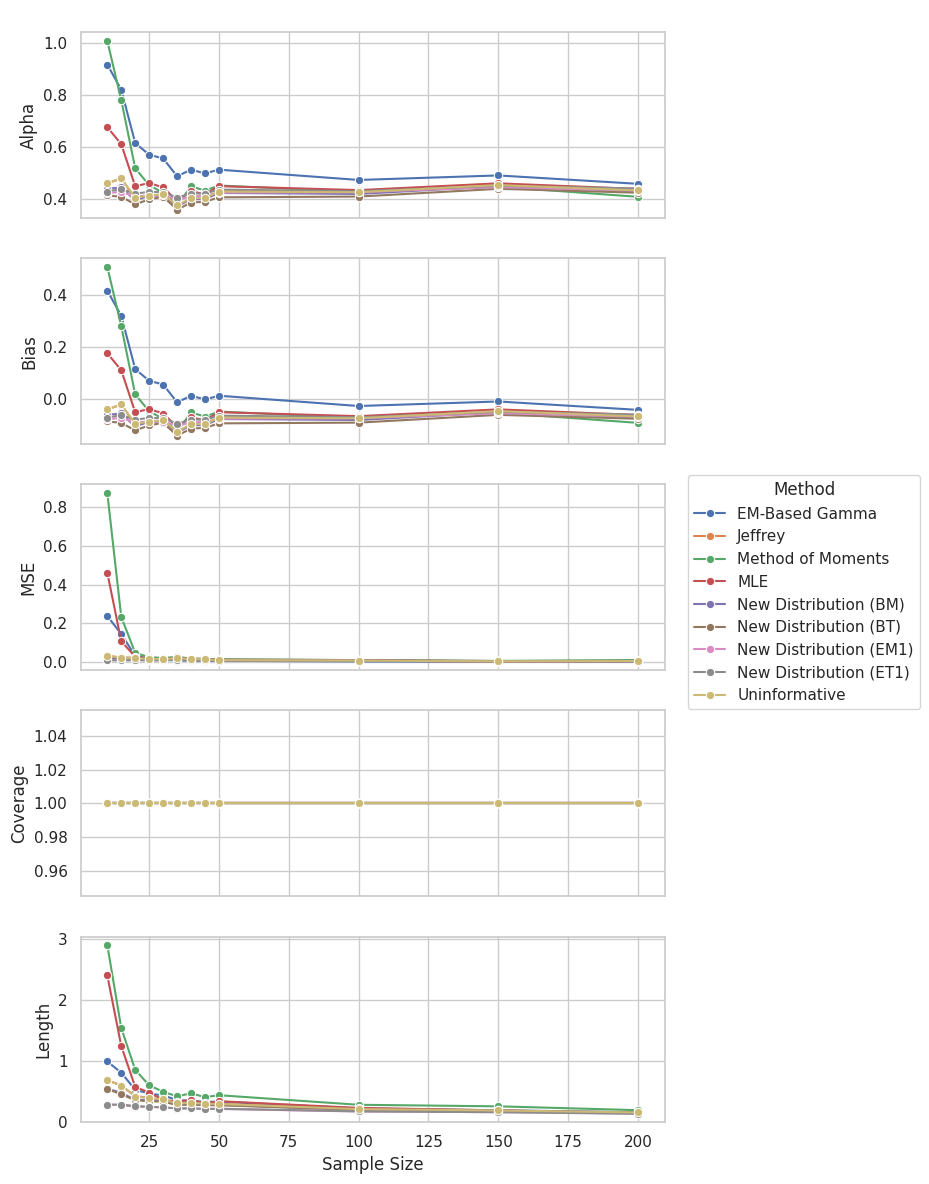

In [ ]:
plot_results(results_3[(results_3['alpha_true']== 0.5) & (results_3['beta_true']== 0.5)], char=["mean_alpha","bias_alpha","mse_alpha","coverage_alpha","length_alpha","Alpha"])

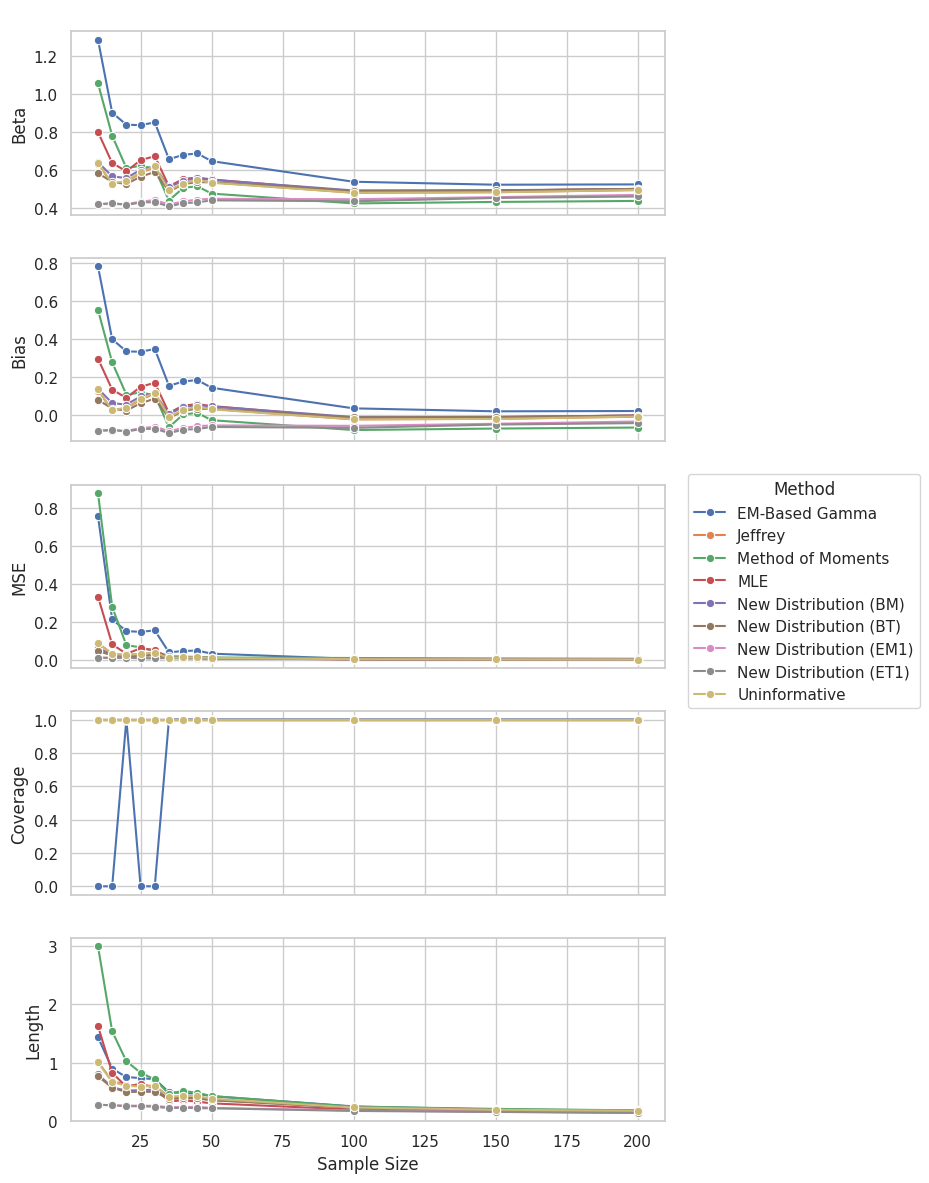

In [ ]:
plot_results(results_3[(results_3['alpha_true']== 0.5) & (results_3['beta_true']== 0.5)], char=["mean_beta","bias_beta","mse_beta","coverage_beta","length_beta","Beta"])

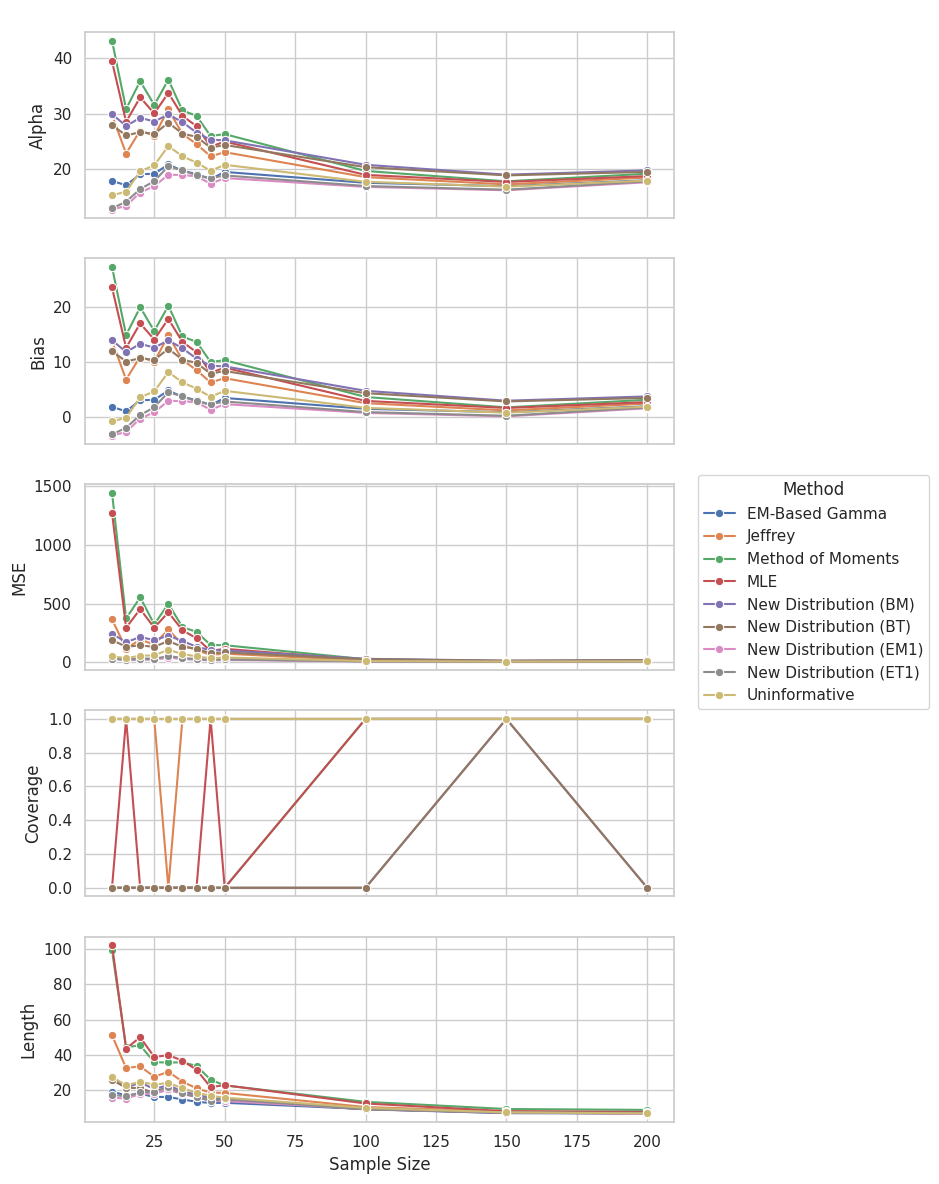

In [ ]:
plot_results(results_3[(results_3['alpha_true']== 16) & (results_3['beta_true']== 4)], char=["mean_alpha","bias_alpha","mse_alpha","coverage_alpha","length_alpha","Alpha"])

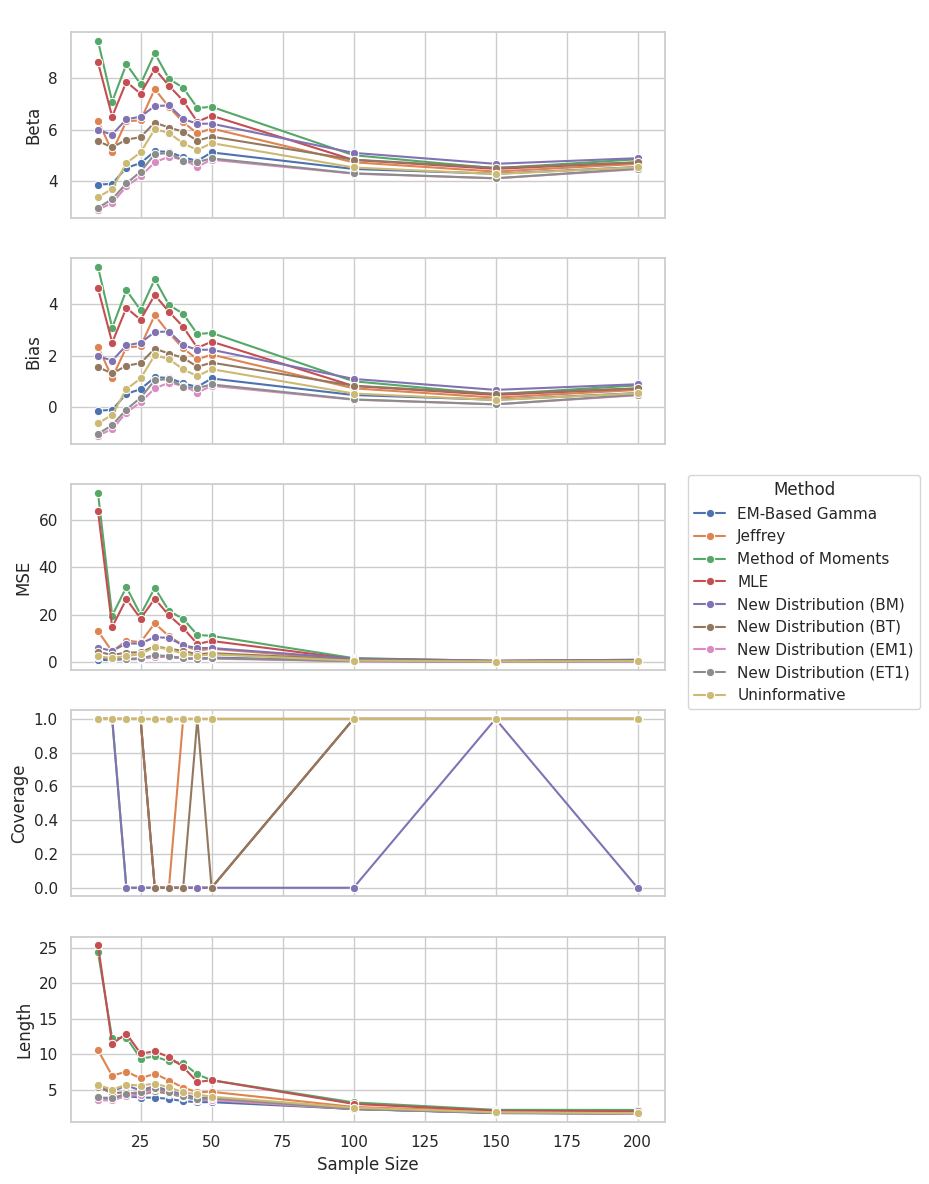

In [ ]:
plot_results(results_3[(results_3['alpha_true']== 16) & (results_3['beta_true']== 4)], char=["mean_beta","bias_beta","mse_beta","coverage_beta","length_beta","Beta"])

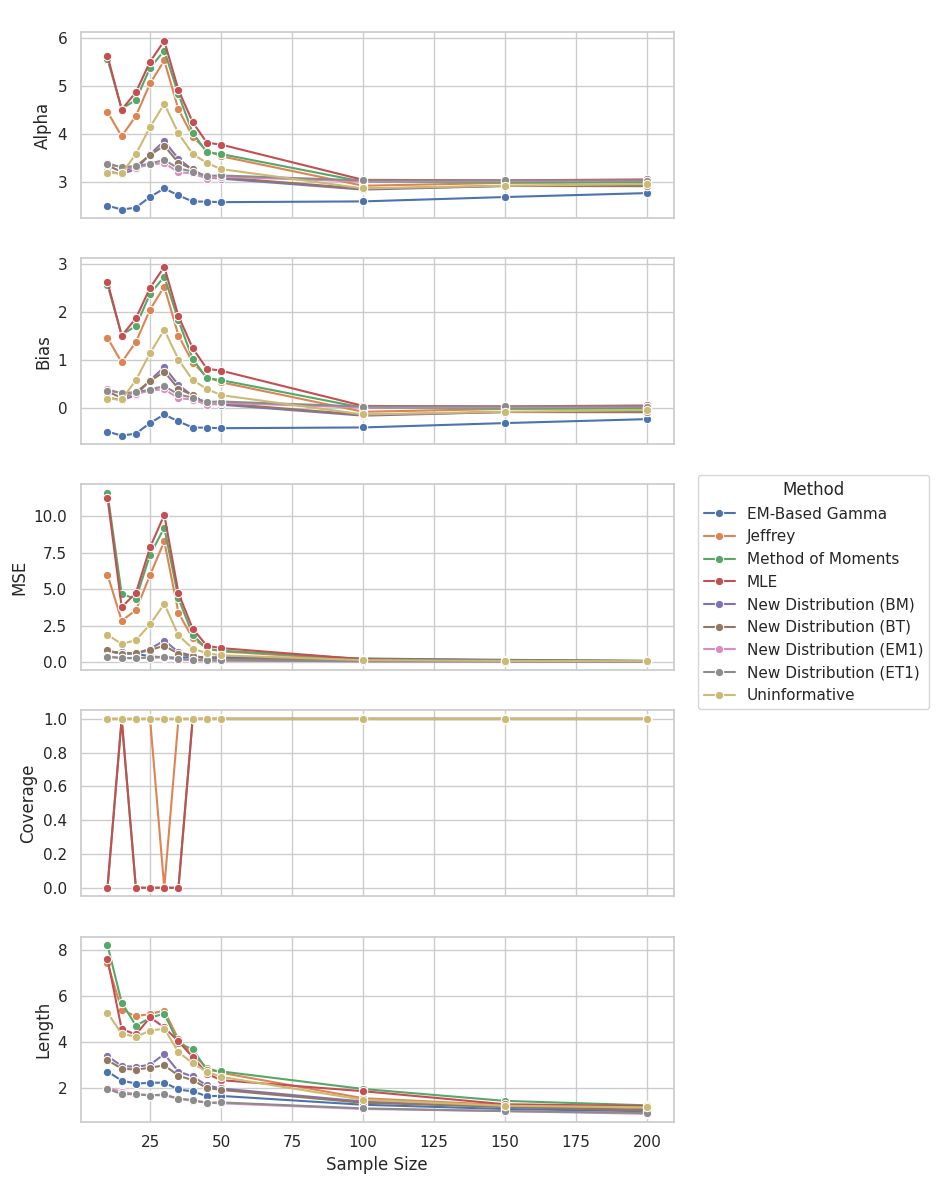

In [ ]:
plot_results(results_3[(results_3['alpha_true']== 3) & (results_3['beta_true']== 12)], char=["mean_alpha","bias_alpha","mse_alpha","coverage_alpha","length_alpha","Alpha"])

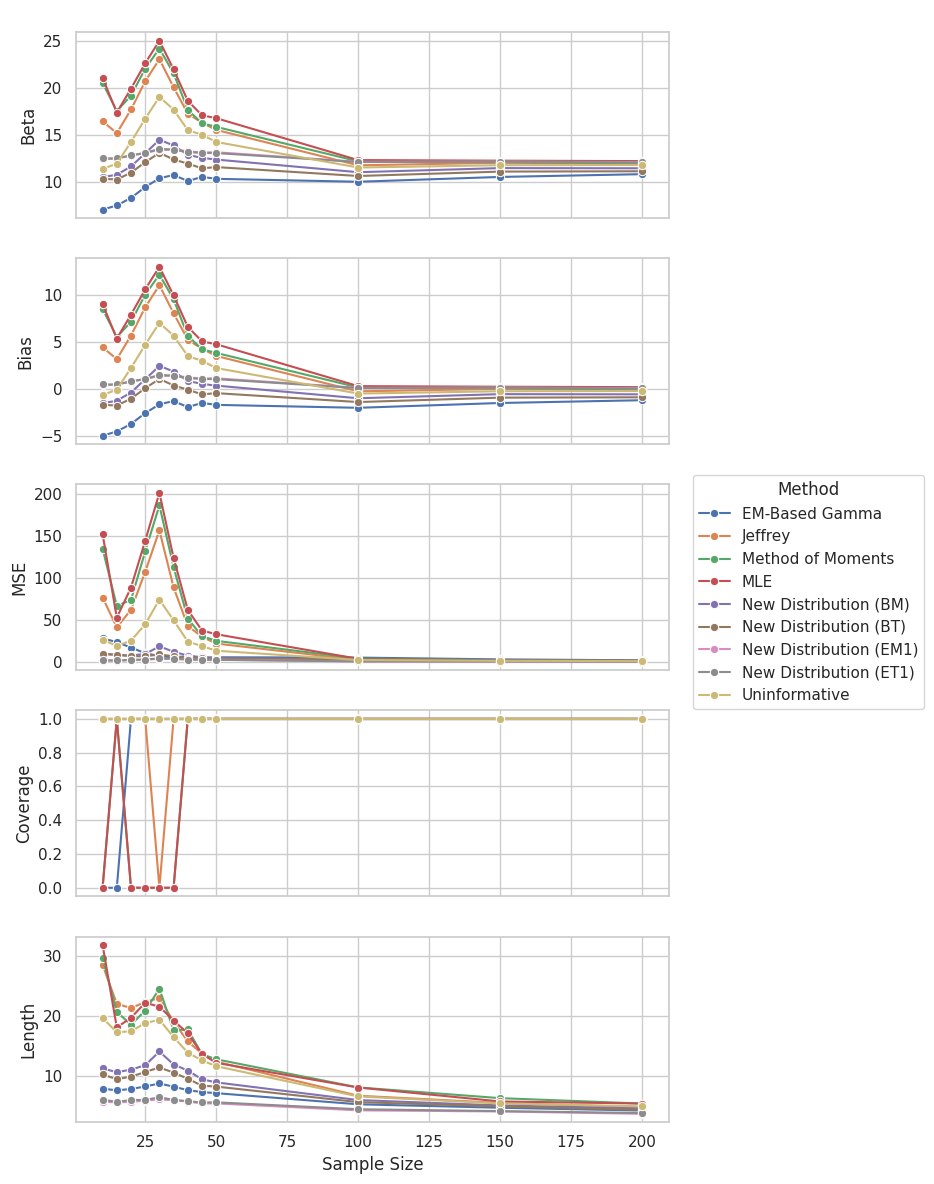

In [ ]:
plot_results(results_3[(results_3['alpha_true']== 3) & (results_3['beta_true']== 12)], char=["mean_beta","bias_beta","mse_beta","coverage_beta","length_beta","Beta"])